## This code is licensed under the Creative Commons Attribution 4.0 International License.
To view a copy of this license, visit: https://creativecommons.org/licenses/by/4.0/
All data used in this script is from the Copernicus Climate Change Service (C3S) and is licensed under the same terms. Copernicus Climate Change Service (2022): Precipitation monthly and daily gridded data from 2000 to 2017 derived from satellite microwave observations. Copernicus Climate Change Service (C3S) Climate Data Store (CDS). 10.24381/cds.e9c9c792 (Accessed on 13-SEP-2025)

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Define the file path for a single file
file_path = "/Users/joeybahret/Documents/Grad_School/ATMS_523/Git_Repo_Code/ATMS-523-1/module_2_assignment/module-2-xarray-dask-and-the-cloud-jbb-illini/data/era5_tp_daily_na.nc"

# Open the single .nc file as an xarray Dataset
# There is no need for Dask, parallel processing, or combining, as there is only one file.
ds = xr.open_dataset(file_path)

# You can now access the data variables from the dataset
# For example, to get the precipitation variable:
# precip_array = ds['precip']

print("Single xarray Dataset loaded successfully!")
print("The 'precip' DataArray is:")
print(ds)

Single xarray Dataset loaded successfully!
The 'precip' DataArray is:
<xarray.Dataset> Size: 4GB
Dimensions:  (time: 27637, lat: 121, lon: 313)
Coordinates:
  * time     (time) datetime64[ns] 221kB 1950-01-01T12:00:00 ... 2025-08-31T1...
  * lon      (lon) float64 3kB 230.0 230.2 230.5 230.8 ... 307.5 307.8 308.0
  * lat      (lat) float64 968B 54.0 53.75 53.5 53.25 ... 24.75 24.5 24.25 24.0
Data variables:
    tp       (time, lat, lon) float32 4GB ...
Attributes: (12/19)
    CDI:                        Climate Data Interface version 2.5.1 (https:/...
    Conventions:                CF-1.6
    institution:                European Centre for Medium-Range Weather Fore...
    frequency:                  day
    title:                      "ERA5 reanalysis, https://www.ecmwf.int/en/fo...
    CDO:                        Climate Data Operators version 2.5.1 (https:/...
    ...                         ...
    geospatial_lat_resolution:  0.25
    geospatial_lon_resolution:  0.25
    time_cover

## (1) Use the precipitation output of ERA-5 to compute a time series of daily precipitation at a given point closest to a city of your choosing. Choose a box of 5 x 5 deg lat-lon values over the grid box closest to the city you are examining.  Save this data. Use a period of at least 10 years.

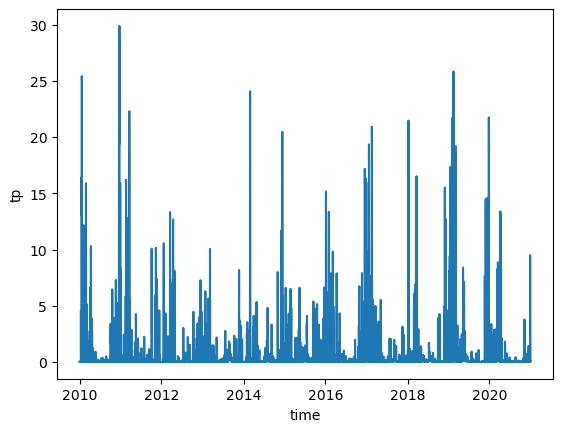

In [2]:
# Do the slicing and take the mean over the region (latitude + longitude).  This data covers the whole period of record.
ds_sub = ds['tp'].sel(
    lat=slice(37.0794, 32.0794),
    lon=slice(360-120.6159, 360-115.6159)
).mean(dim=['lat','lon'])

ds_sub_2010_2020 = ds_sub.sel(
    time = slice('2010-01-01', '2020-12-31')
)
# visualize
ds_sub_2010_2020_computed = ds_sub_2010_2020.compute()
ds_sub_2010_2020_computed.plot()

## (2) Determine the 95% values of daily precipitation for the data created in (1).  Plot a *cumulative distribution function* of all values daily precipitation values and illustrate the 95% value of daily precipitation in millimeters.

The 95th percentile of daily precipitation is: 3.83 mm/day


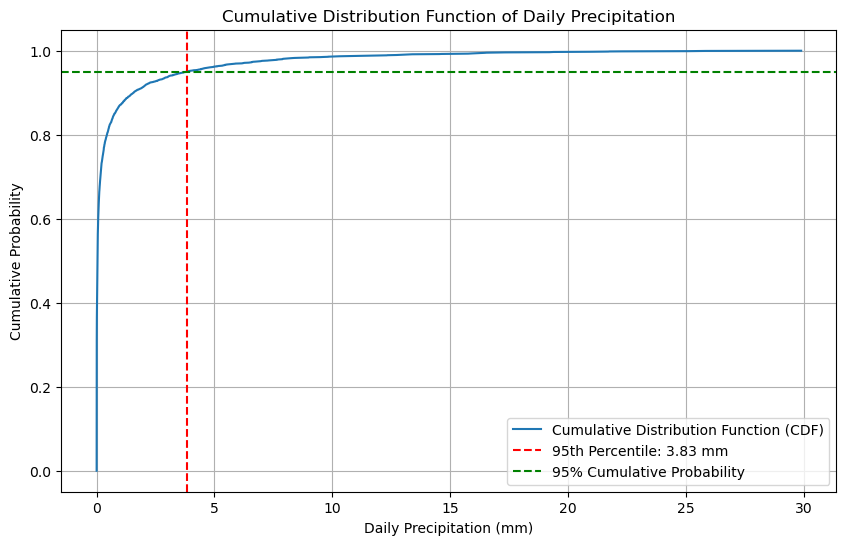

In [3]:
# Extract the numerical values from the xarray DataArray into a NumPy array.
precip_values_2010_2020 = ds_sub_2010_2020_computed.values

# Calculate the 95th percentile of the precipitation data.
p95 = np.percentile(precip_values_2010_2020, 95)
# Print the calculated 95th percentile value, formatted to two decimal places.
print(f"The 95th percentile of daily precipitation is: {p95:.2f} mm/day")

# Sort the precipitation data in ascending order to prepare it for the CDF plot.
sorted_data = np.sort(precip_values_2010_2020)
# Calculate the cumulative distribution function (CDF).
# This creates an array of cumulative probabilities from 0 to 1.It's an array of numbers from 
# 1 to the total number of data points, divided by the total number of data points.
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

# Create a new figure and an axes object for the plot with a specified size.
plt.figure(figsize=(10, 6))
# Plot the CDF. The x-axis is the sorted precipitation data, and the y-axis is the cumulative probability.
plt.plot(sorted_data, cdf, label='Cumulative Distribution Function (CDF)')

# Add a vertical dashed red line at the calculated 95th percentile value on the x-axis.
plt.axvline(x=p95, color='r', linestyle='--', label=f'95th Percentile: {p95:.2f} mm')

# Add a horizontal dashed green line at the 95% cumulative probability on the y-axis.
plt.axhline(y=0.95, color='g', linestyle='--', label='95% Cumulative Probability')

# Set the title of the plot.
plt.title('Cumulative Distribution Function of Daily Precipitation')
# Set the label for the x-axis.
plt.xlabel('Daily Precipitation (mm)')
# Set the label for the y-axis.
plt.ylabel('Cumulative Probability')

# Display the legend, which explains what the lines on the plot represent.
plt.legend()
# Add a grid to the plot for easier reading.
plt.grid(True)

# Save the generated plot to a file named 'cdf_plot.png'.
plt.savefig('cdf_plot.png')

## (3) Create a map of the composite mean precipitation on the 95% days identified in (2) over the continental USA, and a map of the anomaly of precipitation from the 1981-2010 mean. This field should be plotted on a Cartopy map centered at your city with a 40 x 40 degree lat-lon range.

In [7]:
# Create a boolean mask where ds_sub (the time series of regional mean precipitation) is greater than the 95th percentile value
heavy_precip_mask = ds_sub > p95

# Use the mask to select the corresponding time steps from the full dataset (ds)
ds_heavy_precip = ds.sel(time=heavy_precip_mask)

print(f"Identified {len(ds_heavy_precip.time)} days with precipitation above the 95th percentile.")

Identified 1489 days with precipitation above the 95th percentile.


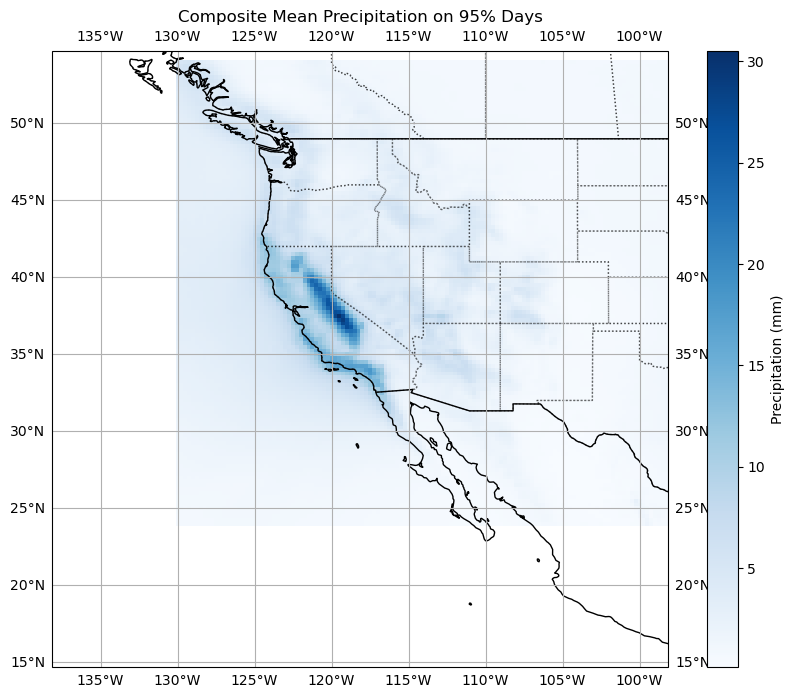

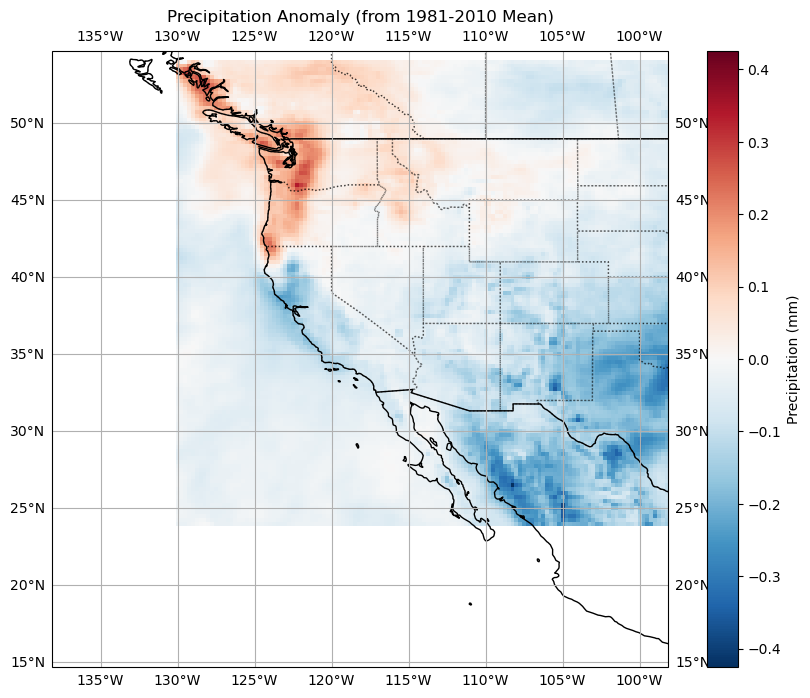

In [8]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- 1. Define Map Parameters ---
# Center the map over Lancaster, CA (latitude 34.69 N, longitude -118.15 W).
# We need to convert the negative longitude to a 0-360 degree system.
center_lon = 360 - 118.15
center_lat = 34.69

# Define the latitude and longitude range for the plot (40 degrees by 40 degrees).
# This creates a box from -20 to +20 degrees around the center point.
lon_range = [center_lon - 20, center_lon + 20]
lat_range = [center_lat - 20, center_lat + 20]


# --- 2. Calculate the Anomaly ---
# We assume 'ds' is your full dataset with a 'tp' (total precipitation) variable.
# We first need to calculate the mean precipitation from the 1981-2010 climatology.
climatology_mean = ds['tp'].sel(time=slice('1981', '2010')).mean(dim='time')

# Then, we calculate the anomaly by subtracting the climatology from the full data.
# The 'climatology_mean' is broadcasted across all time steps.
anomaly_field = ds['tp'] - climatology_mean

# Finally, we take the mean of the anomaly field.
mean_anomaly = anomaly_field.mean(dim='time')


# --- 3. Create a Reusable Plotting Function ---
def create_map(data_array, title, cmap):
    """
    Creates and displays a Cartopy map for a given DataArray.

    Args:
        data_array (xr.DataArray): The data to plot.
        title (str): The title for the plot.
        cmap (str): The colormap to use for the plot.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    # Set the extent based on the predefined lat/lon ranges.
    ax.set_extent(
        [lon_range[0], lon_range[1], lat_range[0], lat_range[1]],
        crs=ccrs.PlateCarree()
    )

    # Add map features for context.
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.STATES, linestyle=':', alpha=0.5)
    ax.add_feature(cfeature.BORDERS)

    # Plot the data using the xarray built-in plot function.
    data_array.plot.pcolormesh(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        cbar_kwargs={'label': 'Precipitation (mm)'}
    )

    # Add a title and gridlines.
    ax.set_title(title)
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

    plt.show()

# --- 4. Generate the Two Maps ---
# Map 1: Composite mean precipitation on the 95% days.
# The 'ds_heavy_precip' variable is assumed to be the mean of the 95th percentile days.
composite_mean_precip = ds_heavy_precip['tp'].mean(dim='time')
create_map(
    composite_mean_precip,
    'Composite Mean Precipitation on 95% Days',
    cmap='Blues'
)

# Map 2: Anomaly of precipitation from the 1981-2010 mean.
create_map(
    mean_anomaly,
    'Precipitation Anomaly (from 1981-2010 Mean)',
    cmap='RdBu_r' # Red-Blue reversed colormap is standard for anomalies.
)